# Read, inspect, and write shapes

In this tutorial, we will read DVP data from a spatialdata storage, inspect the shapes, and select only a few for subsequent processing. We will export this selection to a new LMD-compatible `.xml` file that can be used to continue the DVP workflow. This showcases a typical scenario of the DVP analysis workflow in which only specific cells of interest are selected for MS-based profiling

As example data, we will use the previously generated dataset from the tutorial `Read DVP data into the spatialdata format`. You can also uncomment and execute the following cell if you just want to follow this tutorial

In [1]:
## Uncomment to get example data
#! mkdir -p ./mock-data/blobs/sdata
#! wget -O ./mock-data/blobs/sdata/blobs.sdata.zarr.zip https://datashare.biochem.mpg.de/s/caMGXvZib3Zp7nO/download
#! unzip ./mock-data/blobs/sdata/blobs.sdata.zarr.zip

## Load modules

In [2]:
import spatialdata as sd
from dvpio.write.lmd_writer import write_lmd
import shapely
import geopandas as gpd
import seaborn as sns
from spatialdata.models import ShapesModel

import os
import tempfile

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Load and inspect data 
In a first step, we will load the spatialdata object and visualize the obtained _cell segmentations_ (green outlines)

In [3]:
sdata = sd.read_zarr("./mock-data/blobs/sdata/my_sdata.zarr")
sdata

SpatialData object, with associated Zarr store: /Users/lucas-diedrich/Documents/Projects/scverse/spatialdata/spatialdata-io/dvp-io/dvp-io/docs/tutorials/mock-data/blobs/sdata/my_sdata.zarr
├── Images
│     └── 'blobs': DataArray[cyx] (1, 1024, 1024)
├── Points
│     └── 'calibration_points_image': DataFrame with shape: (<Delayed>, 2) (2D points)
└── Shapes
      └── 'segmentation_masks': GeoDataFrame shape: (62, 3) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        blobs (Images), calibration_points_image (Points), segmentation_masks (Shapes)
    ▸ 'to_lmd', with elements:
        segmentation_masks (Shapes)

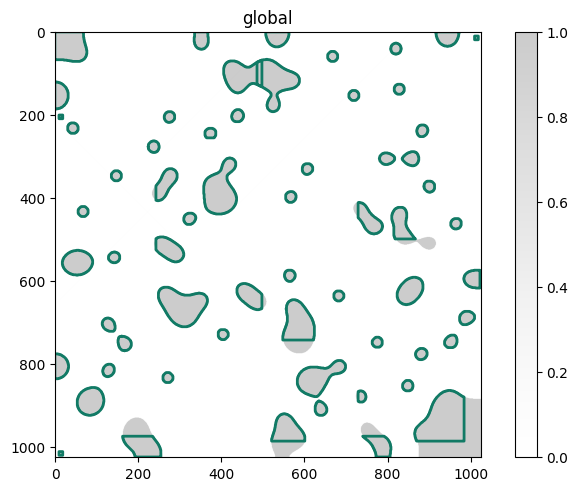

In [4]:
(
    sdata.pl.render_images(cmap="Grays", alpha=0.2)
    .pl.render_shapes(fill_alpha=0, outline_color="#117A65", outline_width=2, outline_alpha=1)
    .pl.show(coordinate_systems="global")
)

The shapes are represented as a `class`:`spatialdata.models.ShapesModel`, which is in its core a `class`:`geopandas.GeoDataFrame`. `class`:`geopandas.GeoDataFrames` behave similarly to `class`:`pandas.DataFrame`s. As you will see, this means that we can easily manipulate them to create selections of our for cells of interest. 

In [5]:
assert isinstance(sdata.shapes["segmentation_masks"], gpd.GeoDataFrame)

## Create selections

In the following, we will use three different selection criteria to select different cells: 

1. A random selection of cells
2. A selection of cells based on a property (here: area)
3. A selection of cells based on their location in a region of interest (ROI)


Subsequently, we will write these subsets to an LMD-compatible `.xml` file. 

### Random selection

First, we will create a random selection of cells. This can be achieved with the built-in method `gpd.GeoDataFrame.sample`

In [6]:
# extract cell segmentation ShapesModel from spatialdata, create copy in memory
gdf = sdata.shapes["segmentation_masks"].copy()
# Get number of cell masks
len(gdf)

62

In [7]:
# Sample 10 cells, reassign them to sdata object
sdata.shapes["segmentation_masks_subset_random"] = gdf.sample(n=10, random_state=42)
len(sdata.shapes["segmentation_masks_subset_random"])

10

Cool! We selected exactly 10 shapes from the cell segmentation. Let's visualize our random selection:

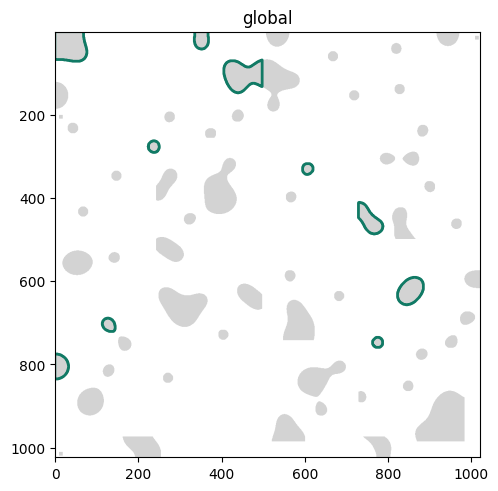

In [8]:
(
    sdata.pl.render_shapes("segmentation_masks")
    # Highlight only selected cell masks
    .pl.render_shapes(
        "segmentation_masks_subset_random", fill_alpha=0, outline_color="#117A65", outline_width=2, outline_alpha=1
    )
    .pl.show(coordinate_systems="global")
)

### Selection based on property

We can also select cells based on a property. To do so, we will first compute the area of each segmented cell with the shapely function `shapely.Polygon.area` and assign it as new column to the ShapesModel. Subsequently, we will create a selection based on this property, following the well-known `.loc` logic.

In [9]:
# Copy ShapesModel
gdf = sdata.shapes["segmentation_masks"].copy()

# Compute and assign area (in Px^2) as new column
gdf["area"] = gdf["geometry"].apply(lambda geom: geom.area)
gdf

,name,well,geometry,area
0,Shape_1,None,"POLYGON ((-0.603 0.518, -0.603 1.518, -0.603 2...",5009.0
1,Shape_2,None,"POLYGON ((-0.603 120.518, -0.603 121.518, -0.6...",1670.5
2,Shape_3,None,"POLYGON ((9.397 200.518, 9.397 201.518, 9.397 ...",81.0
3,Shape_4,None,"POLYGON ((38.397 219.518, 37.397 220.518, 36.3...",518.0
4,Shape_5,None,"POLYGON ((143.397 334.718, 142.397 335.718, 14...",471.0
...,...,...,...,...
57,Shape_58,None,"POLYGON ((729.997 410.718, 728.997 411.718, 72...",2431.5
58,Shape_59,None,"POLYGON ((824.997 422.718, 823.997 423.718, 82...",2631.5
59,Shape_60,None,"POLYGON ((859.997 590.918, 858.997 591.918, 85...",2997.0
60,Shape_61,None,"POLYGON ((944.997 863.118, 943.997 864.118, 94...",10771.5


We can visualize the areas as histograms

<Axes: xlabel='area', ylabel='Count'>

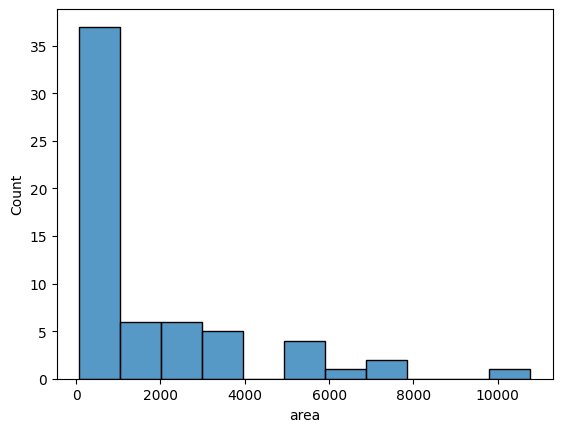

In [10]:
sns.histplot(gdf["area"])

Let's only select the 20 largest masks

In [11]:
gdf = gdf.nlargest(10, "area")
len(gdf)

10

And assign it as new attribute to the spatialdata object

In [12]:
sdata.shapes["segmentation_masks_subset_property"] = gdf

We can check again which shapes we selected

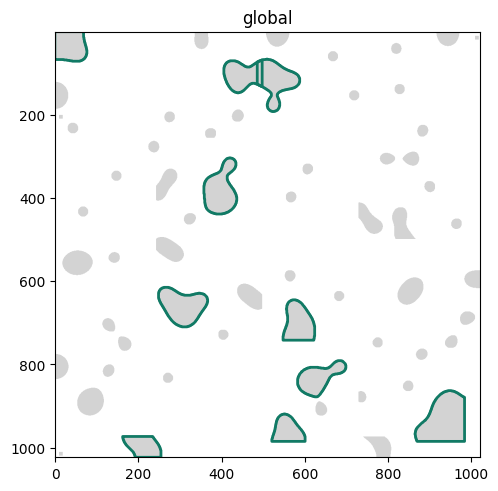

In [13]:
(
    sdata.pl.render_shapes("segmentation_masks")
    # Highlight only selected cell masks
    .pl.render_shapes(
        "segmentation_masks_subset_property", fill_alpha=0, outline_color="#117A65", outline_width=2, outline_alpha=1
    )
    .pl.show(coordinate_systems="global")
)

### Selection based on region of interest

Lastly, we will select all cells that lie in a region of interest. First, we will define this area. Here, we will use napari to interactively define an area of interest. 

In [14]:
## Uncomment the following lines for interactive ROI selection
# interactive = Interactive(sdata)
# interactive.run()

1. Create a new `Shapes` Layer
2. Select the rectangle tool
3. Select the area of interest 
4. Save layer selection with `Shift+E`

![ROI Selection Napari](../_static/img/napari-roi-selection.gif)

Alternatively and for the purpose of reproducibility, you can use the following rectangle to the annotation layer:

In [15]:
roi = shapely.Polygon([[130, 173], [498, 173], [498, 477], [130, 477], [130, 173]])

sdata.shapes["roi"] = ShapesModel.parse(gpd.GeoDataFrame(geometry=[roi]))

Next, we query the `class`:`spatialdata.SpatialData` object for this region of intest. The segmentation masks in this subset are automatically subsetted to the only the shapes within the region of interest: 

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


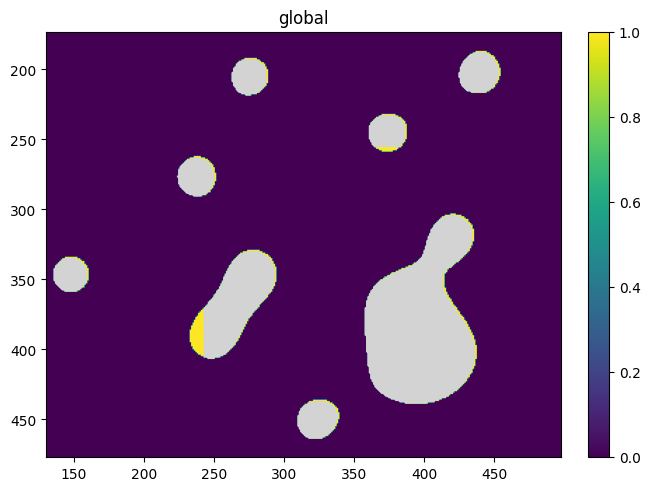

In [22]:
roi = sdata.shapes["roi"].loc[0, "geometry"]
subset = sdata.query.polygon(roi, target_coordinate_system="global")

# Visualize the subset
subset.pl.render_images().pl.render_shapes("segmentation_masks").pl.show(coordinate_systems="global")

Lastly, we extract the associated shapes and assign them to our full spatialdata object

In [17]:
gdf = subset.shapes["segmentation_masks"]
sdata.shapes["segmentation_masks_subset_roi"] = gdf

### Visualize

Let's visualize the shapes

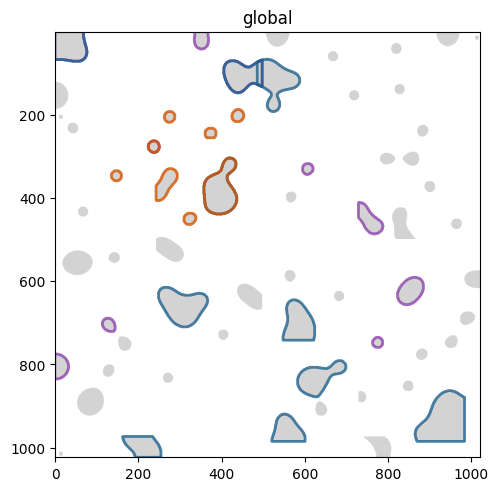

In [18]:
(
    sdata.pl.render_shapes("segmentation_masks")
    # Highlight only selected cell masks
    .pl.render_shapes(
        "segmentation_masks_subset_random", fill_alpha=0, outline_color="#8E44AD", outline_width=2, outline_alpha=0.8
    )  # purple
    .pl.render_shapes(
        "segmentation_masks_subset_property", fill_alpha=0, outline_color="#1F618D", outline_width=2, outline_alpha=0.8
    )  # blue
    .pl.render_shapes(
        "segmentation_masks_subset_roi", fill_alpha=0, outline_color="#D35400", outline_width=2, outline_alpha=0.8
    )  # orange
    .pl.show(coordinate_systems="global")
)

## Write 

Finally, using dvp-io, we can write the selected shapes to a LMD-compatible `.xml` file. This represents a wrapper to the [`pylmd`](https://github.com/MannLabs/py-lmd.git) software package by [Sophia Mädler et al., 2023](https://doi.org/10.1101/2023.06.01.542416)

In [21]:
path_random = os.path.join(tempfile.tempdir, "pylmd-random-subset.xml")
# path_property = os.path.join(tempfile.tempdir, "pylmd-property-subset.xml")
# path_roi = os.path.join(tempfile.tempdir, "pylmd-roi-subset.xml")

write_lmd(
    path_random,
    sdata.shapes["segmentation_masks_subset_random"],
    calibration_points=sdata.points["calibration_points_image"],
)

[101500.  -1500.]
[20500. -1500.]
[   1500. -101500.]


Just for fun, we can inspect the head of the `xml` file

In [27]:
with open(path_random) as f:
    xml = f.read()

# Print head
print(xml[:697])

<?xml version='1.0' encoding='UTF-8'?>
<ImageData>
  <GlobalCoordinates>1</GlobalCoordinates>
  <X_CalibrationPoint_1>101500</X_CalibrationPoint_1>
  <Y_CalibrationPoint_1>-1500</Y_CalibrationPoint_1>
  <X_CalibrationPoint_2>20500</X_CalibrationPoint_2>
  <Y_CalibrationPoint_2>-1500</Y_CalibrationPoint_2>
  <X_CalibrationPoint_3>1500</X_CalibrationPoint_3>
  <Y_CalibrationPoint_3>-101500</Y_CalibrationPoint_3>
  <ShapeCount>10</ShapeCount>
  <Shape_1>
    <PointCount>129</PointCount>
    <X_1>51</X_1>
    <Y_1>-33560</Y_1>
    <X_2>151</X_2>
    <Y_2>-33560</Y_2>
    <X_3>251</X_3>
    <Y_3>-33560</Y_3>
    <X_4>351</X_4>
    <Y_4>-33560</Y_4>
    <X_5>451</X_5>
    <Y_5>-33560</Y_5>
    
